# Test IIR coefficients determination

In [1]:
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.signal import lfilter, lfilter_zi
from scipy.optimize import least_squares, Bounds
from cryoscope_scripts import load_cryoscope_data
from IIR import (
    step,
    inverse_model_IIR,
    residuals_inverse_IIR,
    single_exp_params,
)

from numpy import convolve
from qibocal.protocols.two_qubit_interaction.cryoscope import _fit
from tools import plot_signal_filtered, plot_reconstructed_data, plot_signal_filtered_iter, Signal


FLUX_AMPLITUDE = 0.5
SAMPLING_RATE = 1
DATA_START = 0

[Qibo 0.2.12|INFO|2024-12-18 10:05:32]: Loading platform dummy
[Qibo 0.2.12|INFO|2024-12-18 10:05:32]: Loading platform dummy


In [2]:
data_path = Path.cwd().parent / "cryo_material" / "long_acquisition" / "data" / "cryoscope-0"
data_json = data_path / "data.json"

with open(data_json, "rb") as file:
    data = json.load(file)

flux_pulse_amplitude = data["\"flux_pulse_amplitude\""]
cryoscope_data = load_cryoscope_data(data_path / "data.npz", FLUX_AMPLITUDE)

In [3]:
cryoscope_results = _fit(cryoscope_data)

In [4]:
t = np.arange(0,99,1)
start = 10

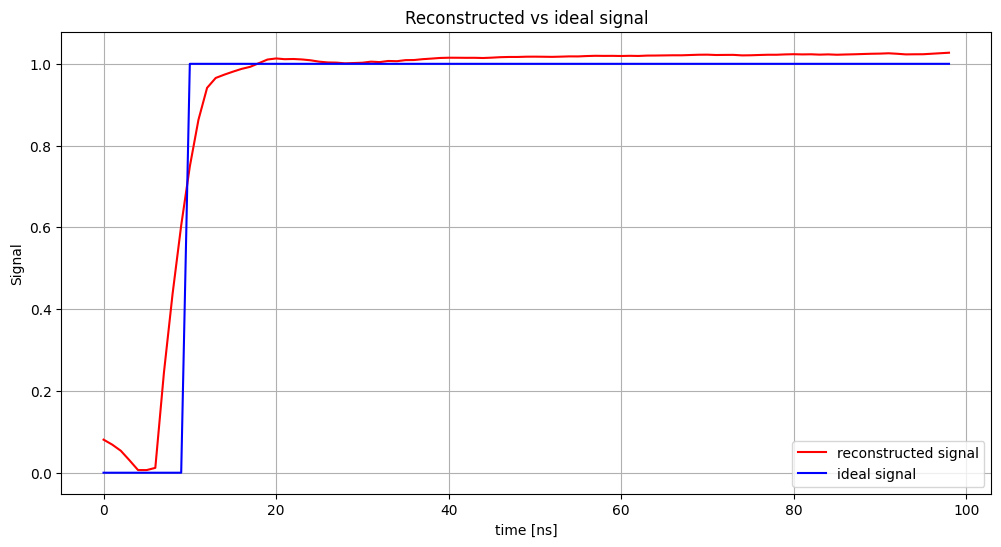

<module 'matplotlib.pyplot' from '/home/elisa/.pyenv/versions/calibration/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [5]:
plot_reconstructed_data(cryoscope_results, "D1", DATA_START, t, start)

**Testing parameters conversion for a single fit**

In [6]:
with open("single_IIR_step.pkl", "rb") as pickle_file:
    result = pickle.load(pickle_file)

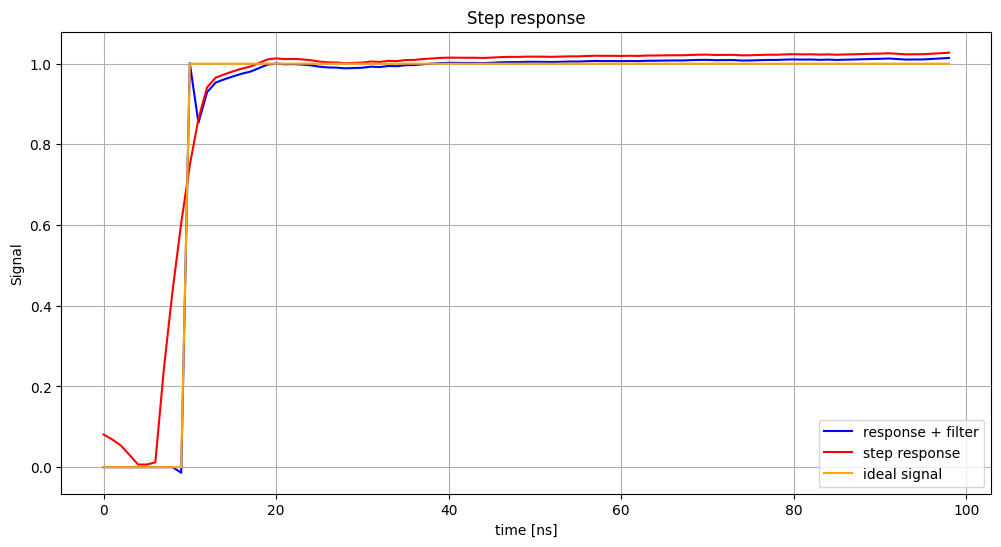

In [7]:
step_response = cryoscope_results.step_response["D1"]

filtered_response = Signal(
    signal=inverse_model_IIR(result.x, t, start, step_response),
    label="response + filter")
response = Signal(signal=step_response, label= "step response")

plot_signal_filtered(filtered_response, response, t, start)

In [8]:
a, b = single_exp_params(result.x, SAMPLING_RATE)
print(a,b)

[ 1.01281825e+00 -9.70538417e-04] [ 1.37118571 -0.359338  ]


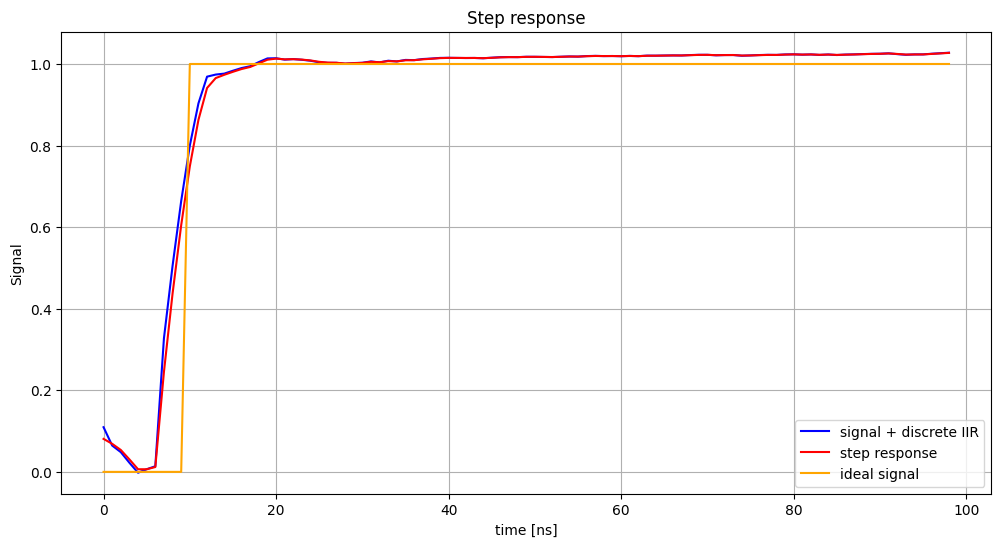

In [9]:
#without computing zi

filtered_response = Signal(
    signal = lfilter(b, a, step_response),
    label = "signal + discrete IIR"
)

plot_signal_filtered(filtered_response, response, t, start)

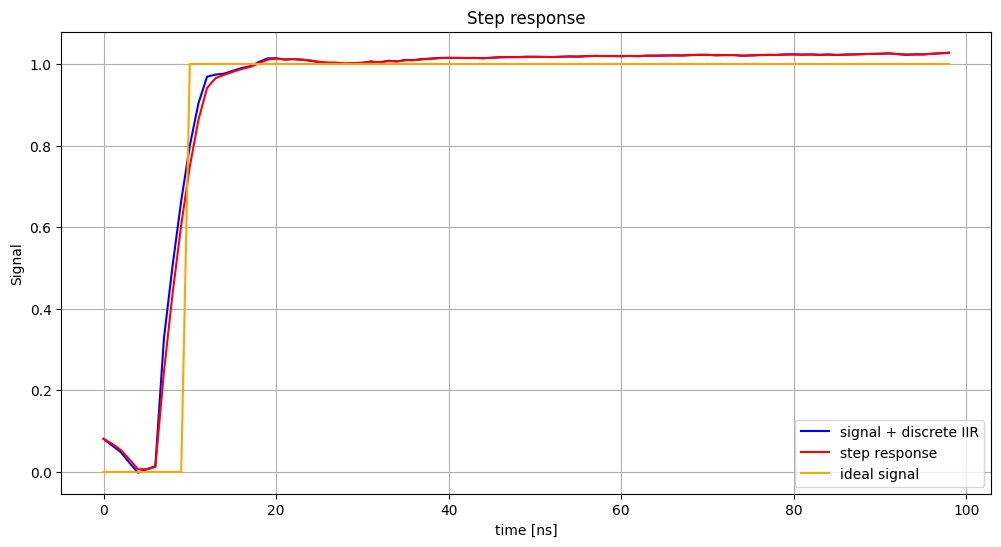

In [10]:
# computing zi
zi = lfilter_zi(b, a) * step_response[0]
filtered, _ = lfilter(b, a, step_response, zi=zi)

filtered_response = Signal(signal=filtered, label="signal + discrete IIR")

plot_signal_filtered(filtered_response, response, t, start)

**Code for filter application iteration**

In [13]:
with open("5IIR_inverse_step.pkl", "rb") as pickle_file:
    results = pickle.load(pickle_file)

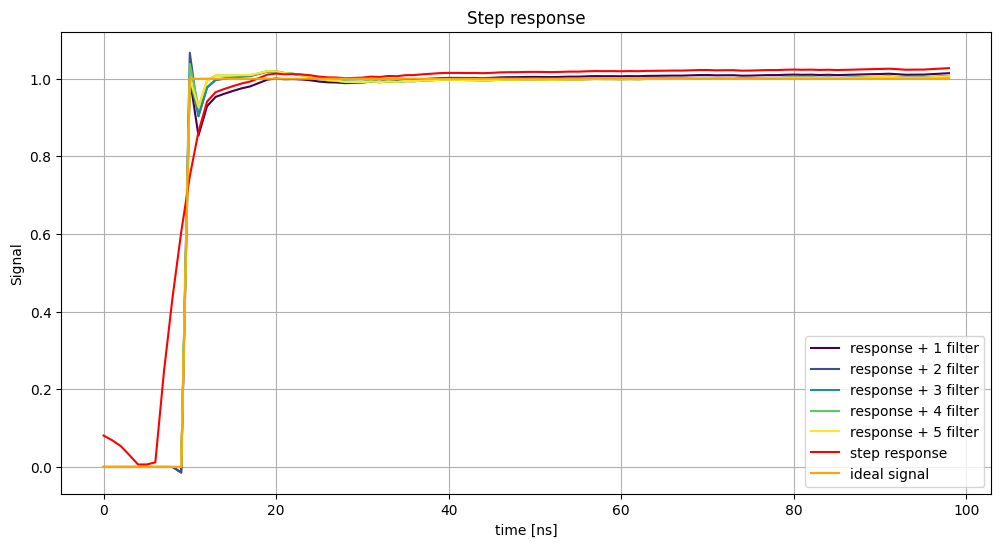

In [15]:
filtered_responses = []

for i in range(5):
    response = inverse_model_IIR(results[i].x, t, start, step_response)
    filtered = Signal(response, f"response + {i+1} filter")
    filtered_responses.append(filtered)
    step_response = inverse_model_IIR(results[i].x, t, start, step_response)
    #last line is to update reference

response = Signal(cryoscope_results.step_response["D1"], label="step response")

plot_signal_filtered_iter(filtered_responses, response, t, start)

In [16]:
b_total = [1]
a_total = [1]

for result in results:
    params = result.x  
    a, b = single_exp_params(params, 1)
    b_total = convolve(b_total, b) 
    a_total = convolve(a_total, a)

print(a_total)
print(b_total)

[ 1.00000000e+00 -1.57699895e+00  6.10518825e-01 -5.83585670e-04
  0.00000000e+00  0.00000000e+00]
[ 1.51131582 -2.80700337  1.57607997 -0.24745614  0.          0.        ]


In [26]:
step_response = cryoscope_results.step_response["D1"]

initial_signal = inverse_model_IIR(results[4].x, t, start, step_response)
zi = lfilter_zi(b_total, a_total) * initial_signal[0]
signal, _ = lfilter(b_total, a_total, step_response, zi=zi)

filtered_response = Signal(signal, label='response + filter')

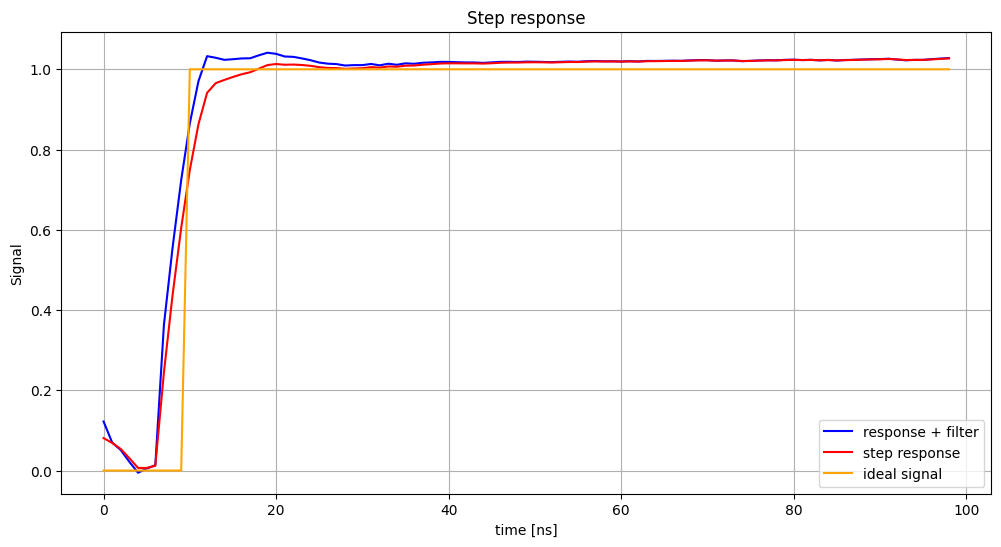

In [27]:
plot_signal_filtered(filtered_response, response, t, start)